# Computer Hardware

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from MachineLearningUtils.preprocessing_data import PreProcessingData
from MachineLearningUtils.svm_learning import SVMLearning
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, binarize, RobustScaler, MinMaxScaler
from MachineLearningUtils.linear_learning import LinearRegressionLearning
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
columns = ['vendor_name', 'model_name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df = pd.read_csv('du lieu cung cap/machine.data.txt', header=None, names=columns)

In [4]:
df.head()

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [5]:
df.shape

(209, 10)

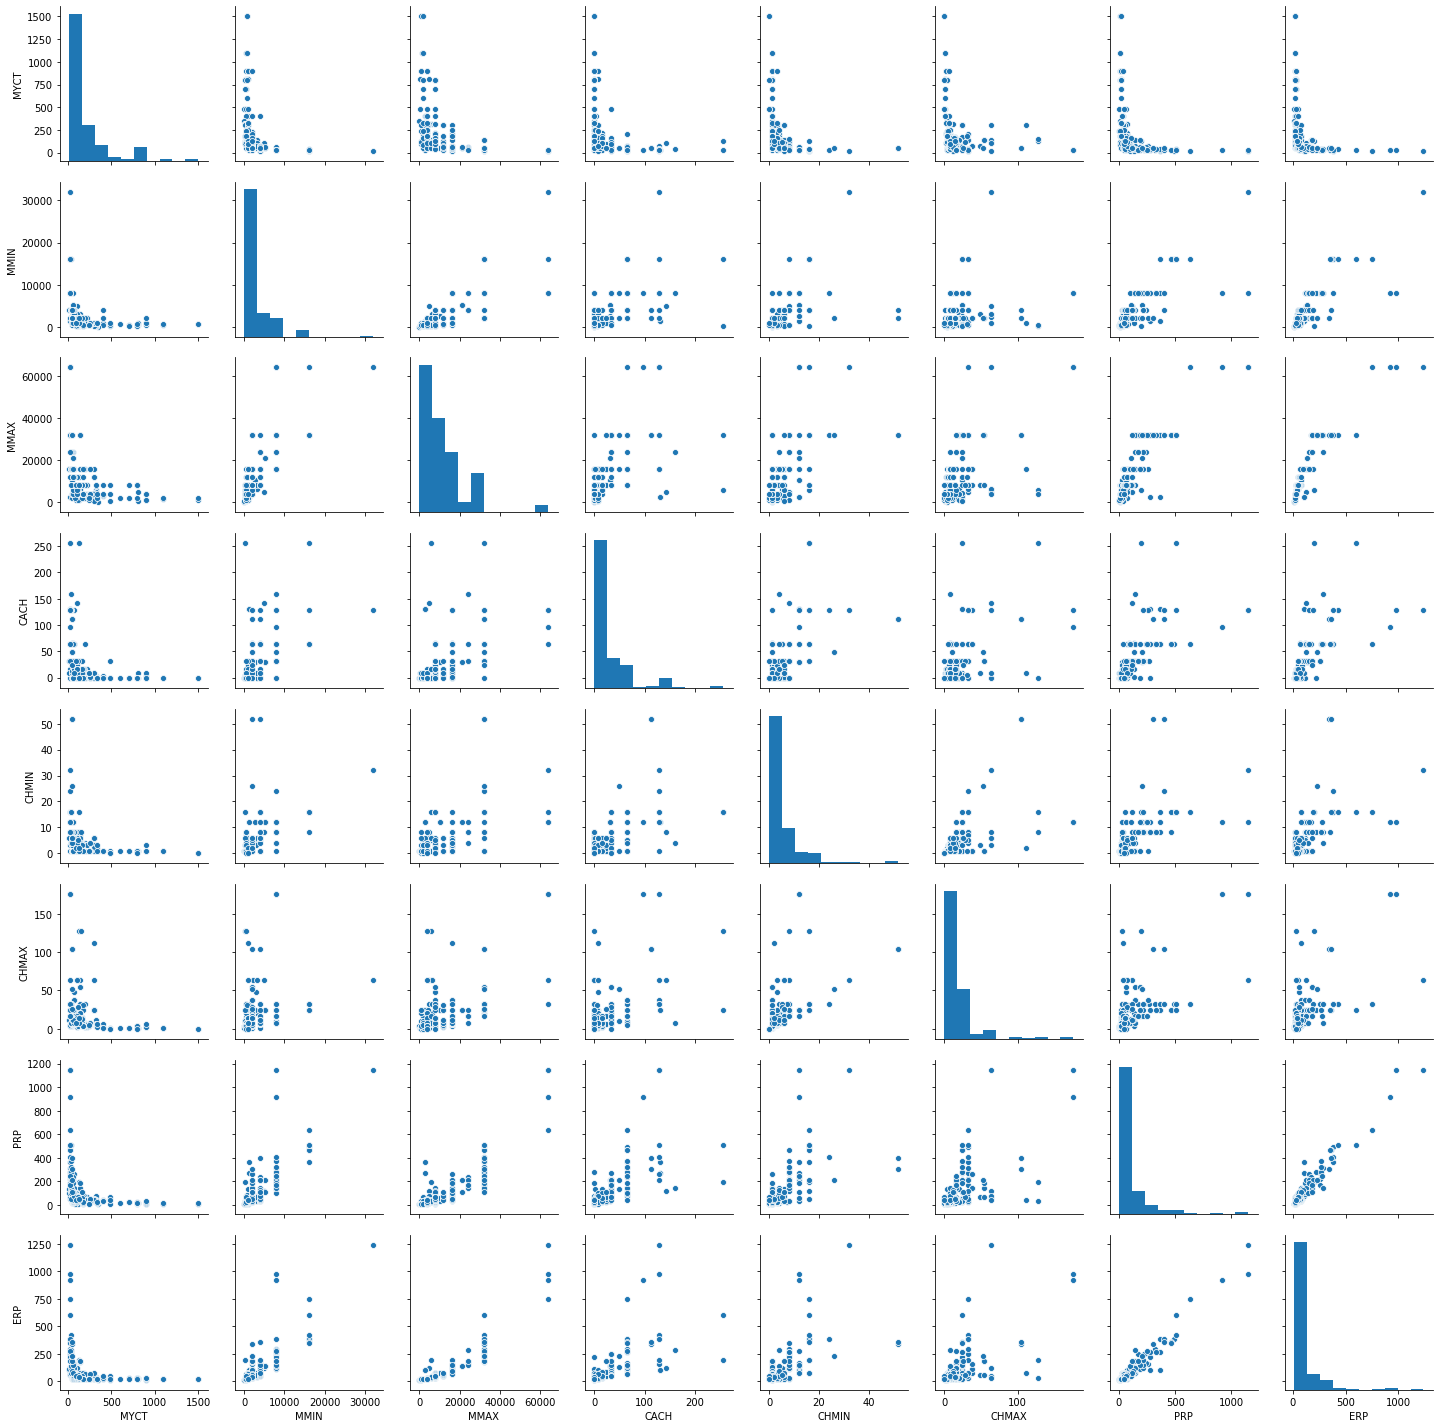

In [6]:
sns.pairplot(df)

1. Các feature có chứ dữ liệu liên tục và dữ liệu category
2. Dữ liệu dự đoán liên tục
3. Các features có chứa outlier
4. Dựa trên đồ thị pair plot, phần lớn các features gần như tuyến tính với với nhau
5. Các feature trong data bị lệch trái
6. Feature 1 là model name là uique trong dữ liệu ==> bỏ feature 2
7. Dữ liệu của các cột có thể cần scale do dữ liệu 
8. Dữ liệu không bị missing data

==> Có thể chọn thuật toán LinearRegression

# Tiền xử lý dữ liệu

In [7]:
df.drop(['model_name'], axis=1, inplace=True)

In [8]:
ppd = PreProcessingData(df, 'regression')

In [9]:
output_col = 'ERP'

In [10]:
le = ppd.label_encode('vendor_name')
inputs = ppd.data.drop([output_col], axis=1)
output = ppd.data[output_col]

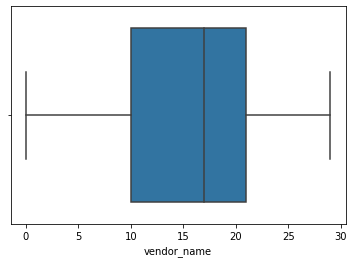

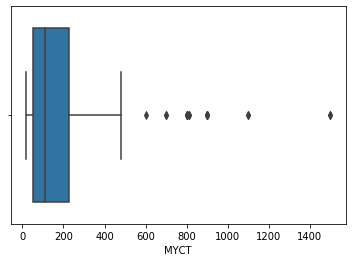

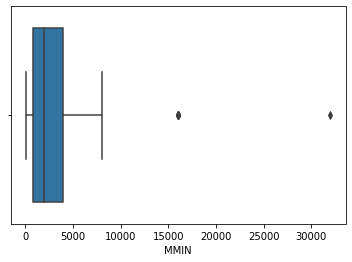

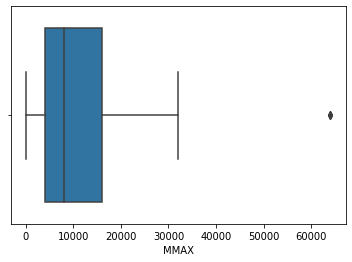

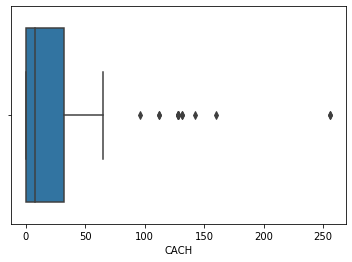

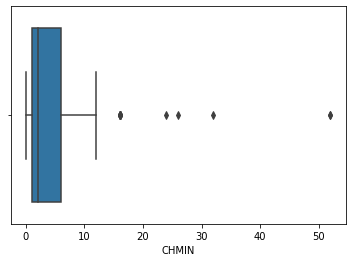

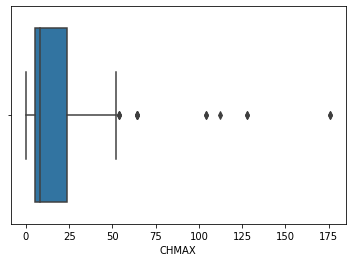

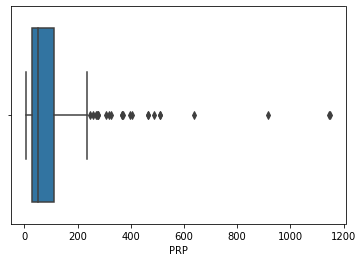

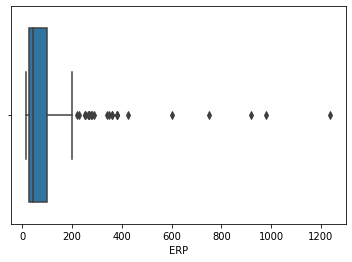

In [11]:
ppd.draw_plot(sns.boxplot)

In [12]:
ppd.get_k_best_features_by_random_forest(output_col, 20)

PRP            0.551375
MMAX           0.337546
MMIN           0.068145
CACH           0.017047
MYCT           0.008528
CHMIN          0.008064
CHMAX          0.007351
vendor_name    0.001944
dtype: float64

In [13]:
ppd._data = ppd.data[['PRP', 'MMAX', output_col]]

## Chọn thuật toán thích hợp để build model

## Áp dụng dữ liệu gốc

In [14]:
ppd.get_best_models(output_col, test_size=0.3)

,model_name,score_mean
0,LinearRegression,0.935273
1,KNeighborsRegressor,0.653910
2,DecisionTreeRegressor,0.883343
3,RandomForestRegressor,0.791331
4,SVR,-0.009339


Từ kết quả của kiểm tra các model ==> chọn SVC algorithms

## Áp dụng dữ liệu sau khi scale

In [15]:
rbs = RobustScaler()
best_cols = ['PRP', 'MMAX', output_col]
rbs.fit(df[best_cols])
tmp = rbs.transform(df[best_cols])
tmp_df = pd.DataFrame(data=tmp, columns=df[best_cols].columns)
tmp_df.head()

,PRP,MMAX,ERP
0,1.720930,-0.166667,2.109589
1,2.546512,2.000000,2.849315
2,1.976744,2.000000,2.849315
3,1.418605,2.000000,2.849315
4,0.953488,0.666667,1.191781


In [16]:
PreProcessingData(tmp_df, 'regression').get_best_models(output_col, test_size=0.3)

,model_name,score_mean
0,LinearRegression,0.935273
1,KNeighborsRegressor,0.657073
2,DecisionTreeRegressor,0.883379
3,RandomForestRegressor,0.792441
4,SVR,0.504250


Từ dữ kết quả chạy thuật toán => chọn LinearRegression

Hơn nữa giữa dữ liệu gốc và sau khi scale data, độ chính xác gần như không thay đổi với

Sử dung Random Forest để lựa chọn ra các feature quan trọng. Chạy lần lượt 3 bộ [PRP, MMAX, MMIN, CACH], [PRP, MMAX, MMIN], [PRP, MMAX] ==> [PRP, MMAX] cho độ chính xác cao nhất

### 1. Tạo X_train, X_test, y_train, y_test từ dữ liệu đã đọc và chuẩn hóa,với tỷ lệ dữ liệu test là 0.3

In [17]:
linear_regression_learning = LinearRegressionLearning(input_data=inputs[['PRP', 'MMAX']], output_data=output, mode='regression')
linear_regression_learning.train_test_split(test_size=0.3)

### 2. Áp dụng thuật toán thích hợpđể xây dựng model. Dựa trên cơ sở nào để cho rằng thuậttoán này thích hợp?

1. Dữ liệu cần dự đoán là 1 dữ liệu liên tục ==> chọn thuật toán liên quan tới regression
2. Từ dữ kết quả build model qua các thuật toán liên quan => chọn LinearRegression
3. Chọn 2 features (PRP, MMAX) từ 10 features có độ tương quan cao với output
4. Từ kết quả chạy predict dữ liệu qua việc scale data, nhận thấy độ chính xác không cải thiện đối với LinearRegression ==> không cần scale data

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(inputs[['PRP', 'MMAX']], output, test_size=0.3, random_state=42)
# from sklearn.linear_model import LinearRegression
# _model = LinearRegression()
# _model.fit(X_train, y_train)
# _model.score(X_train, y_train), _model.score(X_test, y_test)

In [19]:
linear_regression_learning.build_model()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 3. Đánh giá model dựa trên train/test

In [20]:
y_pred = linear_regression_learning.model.predict(linear_regression_learning.X_test)
print('Độ chính xác trên tập Train: ', linear_regression_learning.model.score(linear_regression_learning.X_train, linear_regression_learning.y_train)*100, '%')
print('Độ chính xác trên tập Test: ', linear_regression_learning.model.score(linear_regression_learning.X_test, linear_regression_learning.y_test)*100, '%')
print('Độ chính xác trên toàn dữ liệu: ', linear_regression_learning.model.score(linear_regression_learning._input_data, linear_regression_learning._output_data)*100, '%')

Độ chính xác trên tập Train:  93.49279864353431 %
Độ chính xác trên tập Test:  93.52732471679144 %
Độ chính xác trên toàn dữ liệu:  93.6970010631498 %


Độ chính xác trên tập train và test cao ~93.4%, và gần bằng nhau ==> model không bị overfiting, tính ổn định cao

==> model phù hợp

### 4. Trực quan hóa kết quả dự đoán được từ model

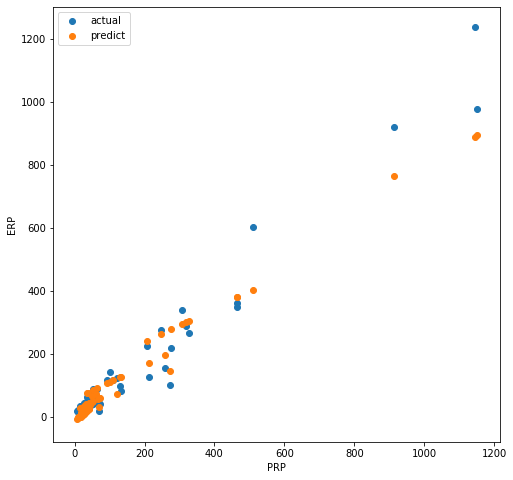

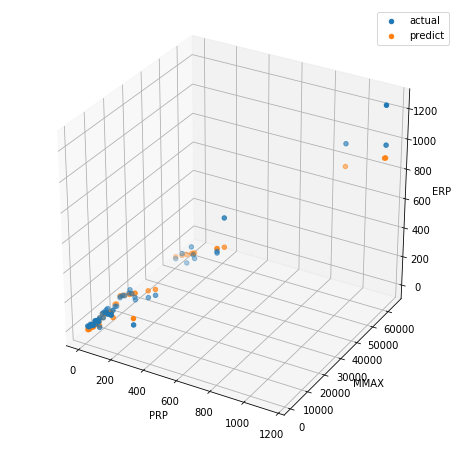

In [21]:
# %matplotlib qt --> uncomment dòng này để view đồ thị trong 3d
linear_regression_learning.plot_scatter('PRP')
linear_regression_learning.plot_scatter('PRP', 'MMAX')

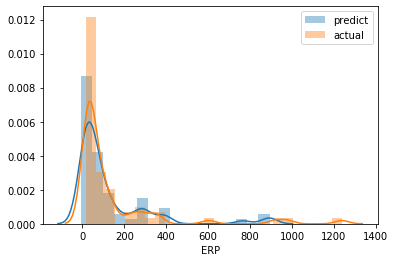

In [22]:
sns.distplot(linear_regression_learning.y_pred, label='predict')
sns.distplot(linear_regression_learning.y_test, label='actual')
plt.legend()

1. Độ chính xác dữ liệu cao
2. Các điểm phân bố tập trung được dự đoán gần như chính xác
3. Các điểm có lượng dữ liệu tập chung thấp, dự đoán bị sai lệch cao (có thể do chưa loại outlier)
4. kde của test và predict gần như trùng nhau

### 5. Với X_new  như  sau: X_new  =  [['amdahl', '470v/7b', 29, 8000, 32000, 32, 8, 32, 172], ['sperry', '1100/83', 50, 2000, 32000, 112, 52, 104, 307]] thì ERP lần lượt là bao nhiêu?

In [23]:
X_new = [['amdahl', '470v/7b', 29, 8000, 32000, 32, 8, 32, 172], ['sperry', '1100/83', 50, 2000, 32000, 112, 52, 104, 307]]

In [24]:
X_new_df = pd.DataFrame(X_new, columns=columns[:9])
X_new_input = X_new_df[['PRP', 'MMAX']]

In [25]:
print('Giá trị dự đoán tương ứng', linear_regression_learning.model.predict(X_new_input))

Giá trị dự đoán tương ứng [221.84319517 294.79004664]
